In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### a)

In [29]:
df = pd.read_excel("data/sv.xlsx")
df.head()

,GBPUSD
0,-0.355532
1,1.425409
2,-0.443940
3,1.025650
4,1.677579


In [51]:
df['returns'] = np.exp(df['GBPUSD']/100) - 1
print(df['returns'].describe())
df

count    945.000000
mean      -0.000328
std        0.007124
min       -0.032424
25%       -0.004384
50%       -0.000457
75%        0.003651
max        0.046389
Name: returns, dtype: float64


,GBPUSD,returns,xt
0,-0.355532,-0.003549,-2.277486
1,1.425409,0.014356,0.757858
2,-0.443940,-0.004430,-1.789892
3,1.025650,0.010309,0.118349
4,1.677579,0.016917,1.076363
...,...,...,...
940,0.428767,0.004297,-1.535409
941,-0.093392,-0.000933,-5.691791
942,0.891444,0.008954,-0.152133
943,-0.945963,-0.009415,-0.187186


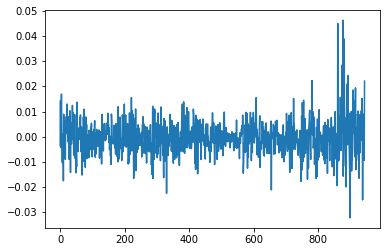

In [54]:
plt.plot(df['returns'])
plt.show()


### b)

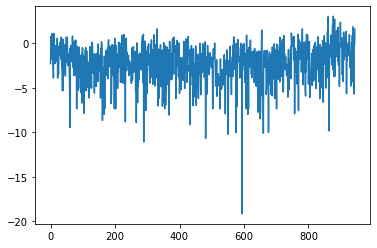

In [48]:
df['xt'] = np.log((df['GBPUSD'] - df['GBPUSD'].mean())**2)
plt.plot(df['xt'])
plt.show()

### c)

### d)

### e)

### f)